In [ ]:
!python --version

Python 3.7.10


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
combined_data = pd.read_csv('cleaned_data.csv')

In [5]:
combined_data.head()

,T,TM,Tm,H,PP,VV,V,VM,PM_2_5
0,23.4,30.3,19.0,59.0,0.0,6.3,4.3,5.4,284.795833
1,22.4,30.3,16.9,57.0,0.0,6.9,3.3,7.6,239.695455
2,24.0,31.8,16.9,51.0,0.0,6.9,2.8,5.4,182.187500
3,22.8,30.2,17.6,55.0,0.0,7.7,3.7,7.6,264.064286
4,23.1,30.6,17.4,46.0,0.0,6.9,3.3,5.4,223.208333


In [6]:
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [8]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[06:08:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [10]:
f'Coefficient of determination R^2 on train set {xgb.score(X_train, y_train)}'
# must be close to 1, 1 is perfect fit

'Coefficient of determination R^2 on train set 0.8075419986616452'

In [11]:
f'Coefficient of determination R^2 on test set {xgb.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.36292781401846796'

In [13]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb, X, y, cv = 3)

[06:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [14]:
score.mean()

0.29975471126334907

In [15]:
pred = xgb.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


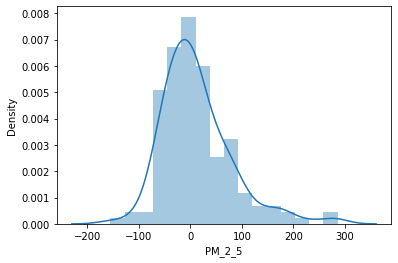

In [16]:
sns.distplot(y_test - pred)

In [17]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
subsample = [0.7, 0.6, 0.8]
min_child_weight = list(range(3, 8))
objective = ['reg:squarederror']
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'min_child_weight': min_child_weight,
    'objective': objective
}

In [18]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(xgb, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=100, random_state=43, n_jobs=-1, verbose=True)
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6],
                                   

In [19]:
search.best_params_

{'learning_rate': 0.05,
 'max_depth': 20,
 'min_child_weight': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [20]:
search.best_score_

-5025.3837576089745

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


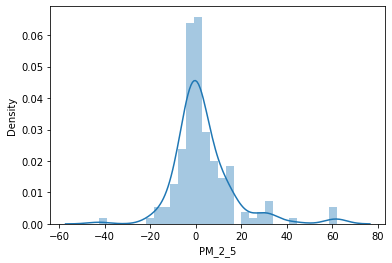

In [21]:
pred = search.predict(X_test)
sns.distplot(y_test-pred)

In [22]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 8.277064511406477
Mean Sq Error: 192.08441507308692
Root Mean Error: 13.859452192387941


In [23]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [24]:
import pickle
pickle.dump(search, open('xgb.pkl', 'wb'))